In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools
import statsmodels.api as sm
from sklearn.externals import joblib

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data

### Importing Raw Data

In [3]:
# Importing the csv file
data = pd.read_csv('ITSM_data.csv')

## Source Code

### Exploratory Data Analysis

In [4]:
data.shape

(46606, 25)

In [5]:
data.columns

Index(['CI_Name', 'CI_Cat', 'CI_Subcat', 'WBS', 'Incident_ID', 'Status',
       'Impact', 'Urgency', 'Priority', 'number_cnt', 'Category', 'KB_number',
       'Alert_Status', 'No_of_Reassignments', 'Open_Time', 'Reopen_Time',
       'Resolved_Time', 'Close_Time', 'Handle_Time_hrs', 'Closure_Code',
       'No_of_Related_Interactions', 'Related_Interaction',
       'No_of_Related_Incidents', 'No_of_Related_Changes', 'Related_Change'],
      dtype='object')

In [6]:
data.head(3)

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,...,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4.0,0.601292,...,NaN,4/11/2013 13:50,4/11/2013 13:51,"3,87,16,91,111",Other,1.0,SD0000007,2.0,NaN,NaN
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3.0,0.415050,...,2/12/2013 12:31,2/12/2013 12:36,2/12/2013 12:36,"4,35,47,86,389",Software,1.0,SD0000011,1.0,NaN,NaN
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NaN,0.517551,...,NaN,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1.0,SD0000017,NaN,NaN,NaN


In [7]:
# Looking for missing data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
CI_Name                       46606 non-null object
CI_Cat                        46495 non-null object
CI_Subcat                     46495 non-null object
WBS                           46606 non-null object
Incident_ID                   46606 non-null object
Status                        46606 non-null object
Impact                        46606 non-null object
Urgency                       46606 non-null object
Priority                      45226 non-null float64
number_cnt                    46606 non-null float64
Category                      46606 non-null object
KB_number                     46606 non-null object
Alert_Status                  46606 non-null object
No_of_Reassignments           46605 non-null float64
Open_Time                     46606 non-null object
Reopen_Time                   2284 non-null object
Resolved_Time                 44826 non-null object
Close

### Data Processing / Data Munging
CI Category & CI Subcategory had a lot of labels which were replaced  to only take the major ones. Unknown values were replaced by Mode values.

In [8]:
data.CI_Cat.replace(['database'],'storage',inplace=True)
data.CI_Cat.replace(['applicationcomponent'],'subapplication',inplace=True)
data.CI_Cat.replace(['displaydevice','officeelectronics','Phone','networkcomponents'],'hardware',inplace=True)
data.CI_Cat.replace(np.nan,'application',inplace=True)

In [9]:
data.CI_Subcat.replace('Desktop','Desktop Application',inplace=True)
data.CI_Subcat.replace(['Application Server','Virtual Tape Server','ESX Server','zOS Server','Neoview Server','X86 Server',
                       'Unix Server','Oracle Server','Windows Server in extern beheer','Thin Client','NonStop Server',
                       'Number','Windows Server','Linux Server',np.nan,'SharePoint Farm','Lines'],
                       'Server Based Application',inplace=True)
data.CI_Subcat.replace('RAC Service','Banking Device',inplace=True)
data.CI_Subcat.replace(['Iptelephony','Protocol','Net Device','IPtelephony','ESX Cluster','Standard Application'],
                       'Web Based Application',inplace=True)
data.CI_Subcat.replace(['VMWare','Security Software','zOS Systeem','Firewall','Database Software','VDI','Instance',
                       'MQ Queue Manager','Automation Software','Citrix','SAP','Encryption'],'System Software',inplace=True)
data.CI_Subcat.replace(['UPS','Omgeving'],'Client Based Application',inplace=True)
data.CI_Subcat.replace(['NonStop Storage','NonStop Harddisk','Tape Library','zOS Cluster','DataCenterEquipment',
                       'MigratieDummy'],'Database',inplace=True)
data.CI_Subcat.replace(['Modem','Router'],'Network Component',inplace=True)
data.CI_Subcat.replace('KVM Switches','Switch',inplace=True)

In [10]:
data.No_of_Related_Interactions.replace(np.nan,1,inplace=True)
data.Priority.replace(np.nan,4,inplace=True)
data.No_of_Related_Incidents.replace(np.nan,0,inplace=True)
data.No_of_Related_Changes.replace(np.nan,0,inplace=True)

## 1. Predicting Priorities

### Feature Selection
Only the features which are available when the tickets arrives can be used to predict priority. Therefore, we have used only 4 predictors.

In [11]:
X = data.loc[:,['CI_Cat','CI_Subcat','WBS','Category']]
y = data.Priority

In [12]:
X.head(2)

,CI_Cat,CI_Subcat,WBS,Category
0,subapplication,Web Based Application,WBS000162,incident
1,application,Web Based Application,WBS000088,incident


In [13]:
# Label Encoding
enc= LabelEncoder()
for i in (0,1,2,3):
    X.iloc[:,i] = enc.fit_transform(X.iloc[:,i])

In [14]:
# Splitting the data into test and train for calculating accuracy
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=10)

In [15]:
# Standardization technique
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [16]:
X_train.shape

(32624, 4)

In [17]:
X_test.shape

(13982, 4)

## Models

### 1. Support Vector Machine

In [18]:
# Training the model
from sklearn.svm import SVC
rbf_svc = SVC(kernel='rbf',C=10,gamma=0.1).fit(X_train,y_train)

In [19]:
# Predicting the model
y_predict_svm = rbf_svc.predict(X_test)

In [20]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_svm))
print(classification_report(y_test,y_predict_svm))

0.747604062365899
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.52      0.65      0.58       210
         3.0       0.55      0.31      0.39      1581
         4.0       0.72      0.89      0.80      7254
         5.0       0.87      0.68      0.76      4936

   micro avg       0.75      0.75      0.75     13982
   macro avg       0.53      0.51      0.51     13982
weighted avg       0.75      0.75      0.74     13982



In [21]:
confusion_matrix(y_test,y_predict_svm)

array([[   0,    0,    0,    1,    0],
       [   0,  137,    8,   56,    9],
       [   0,   36,  486,  958,  101],
       [   0,   78,  314, 6477,  385],
       [   0,   10,   79, 1494, 3353]], dtype=int64)

### 2. Decision Tree

In [22]:
# Training the model
from sklearn.tree import DecisionTreeClassifier
model_dtree=DecisionTreeClassifier()
model_dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
# Predicting the model
y_predict_dtree = model_dtree.predict(X_test)

In [24]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_dtree))
print(classification_report(y_test,y_predict_dtree))

0.81690745243885
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.52      0.69      0.59       210
         3.0       0.66      0.63      0.65      1581
         4.0       0.82      0.87      0.85      7254
         5.0       0.88      0.80      0.84      4936

   micro avg       0.82      0.82      0.82     13982
   macro avg       0.58      0.60      0.58     13982
weighted avg       0.82      0.82      0.82     13982



In [25]:
confusion_matrix(y_test,y_predict_dtree)

array([[   0,    0,    0,    1,    0],
       [   0,  144,    6,   43,   17],
       [   0,   42,  999,  419,  121],
       [   0,   80,  458, 6325,  391],
       [   0,   12,   51,  919, 3954]], dtype=int64)

### 3. Random Forest

In [26]:
# Training the model
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(max_depth=27)
model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=27, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
# Predicting the model
y_predict_rf = model_rf.predict(X_test)

In [28]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_rf))
print(classification_report(y_test,y_predict_rf))

0.8168359319124588
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.53      0.68      0.59       210
         3.0       0.66      0.62      0.64      1581
         4.0       0.82      0.87      0.85      7254
         5.0       0.88      0.80      0.84      4936

   micro avg       0.82      0.82      0.82     13982
   macro avg       0.58      0.60      0.58     13982
weighted avg       0.82      0.82      0.82     13982



In [29]:
confusion_matrix(y_test,y_predict_rf)

array([[   0,    0,    0,    1,    0],
       [   0,  142,    6,   45,   17],
       [   0,   39,  987,  433,  122],
       [   0,   77,  452, 6336,  389],
       [   0,   12,   47,  921, 3956]], dtype=int64)

### 4. K-Nearest Neighbor

In [30]:
# Training the model
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=12,metric='euclidean') # Maximum accuracy for n=10
model_knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=None, n_neighbors=12, p=2,
           weights='uniform')

In [31]:
# Predicting the model
y_predict_knn = model_knn.predict(X_test)

In [32]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_knn))
print(classification_report(y_test,y_predict_knn))

0.8133314261192962
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.51      0.67      0.58       210
         3.0       0.66      0.62      0.64      1581
         4.0       0.81      0.87      0.84      7254
         5.0       0.88      0.79      0.84      4936

   micro avg       0.81      0.81      0.81     13982
   macro avg       0.57      0.59      0.58     13982
weighted avg       0.82      0.81      0.81     13982



In [33]:
confusion_matrix(y_test,y_predict_knn)

array([[   0,    0,    0,    1,    0],
       [   0,  141,    7,   47,   15],
       [   0,   42,  986,  432,  121],
       [   0,   80,  460, 6339,  375],
       [   0,   14,   51,  965, 3906]], dtype=int64)

### 5. XGBoost Classifier

In [34]:
# Training the model
from xgboost import XGBClassifier
model_xgb = XGBClassifier()
model_xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [35]:
# Predicting the model
y_predict_xgb = model_xgb.predict(X_test)

In [36]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_xgb))
print(classification_report(y_test,y_predict_xgb))

0.7924474324131026
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.53      0.65      0.59       210
         3.0       0.67      0.41      0.51      1581
         4.0       0.77      0.89      0.83      7254
         5.0       0.87      0.77      0.82      4936

   micro avg       0.79      0.79      0.79     13982
   macro avg       0.57      0.55      0.55     13982
weighted avg       0.79      0.79      0.79     13982



In [37]:
confusion_matrix(y_test,y_predict_xgb)

array([[   0,    0,    0,    1,    0],
       [   0,  137,    3,   56,   14],
       [   0,   36,  647,  776,  122],
       [   0,   75,  267, 6492,  420],
       [   0,   10,   46, 1076, 3804]], dtype=int64)

### 6. Artificial Neural Network

In [38]:
# Training the model
from sklearn.neural_network import MLPClassifier
model_mlp = MLPClassifier()
model_mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [39]:
# Predicting the model
y_predict_mlp = model_mlp.predict(X_test)

In [40]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_mlp))
print(classification_report(y_test,y_predict_mlp))

0.7679874123873551
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.52      0.65      0.58       210
         3.0       0.61      0.39      0.48      1581
         4.0       0.74      0.89      0.81      7254
         5.0       0.88      0.71      0.79      4936

   micro avg       0.77      0.77      0.77     13982
   macro avg       0.55      0.53      0.53     13982
weighted avg       0.77      0.77      0.76     13982



In [41]:
confusion_matrix(y_test,y_predict_mlp)

array([[   0,    0,    0,    1,    0],
       [   0,  137,    6,   57,   10],
       [   0,   36,  617,  825,  103],
       [   0,   78,  334, 6479,  363],
       [   0,   10,   57, 1364, 3505]], dtype=int64)

In [42]:
# Exporting the trained model
joblib.dump(model_rf,'Predicting_Priority.ml')

['Predicting_Priority.ml']

## 2. Predicting Request For Change (RFC)

### Feature Selection

In [43]:
# Selecting the predictors
X1 = data.loc[:,['CI_Subcat','WBS','Priority','Category','No_of_Related_Interactions','No_of_Related_Incidents']]
y1 = data.No_of_Related_Changes

In [44]:
X1.head(2)

,CI_Subcat,WBS,Priority,Category,No_of_Related_Interactions,No_of_Related_Incidents
0,Web Based Application,WBS000162,4.0,incident,1.0,2.0
1,Web Based Application,WBS000088,3.0,incident,1.0,1.0


In [45]:
enc= LabelEncoder()
for i in (0,1,3,4):
    X1.iloc[:,i] = enc.fit_transform(X1.iloc[:,i])

In [46]:
# Splitting into train and test for calculating the accuracy
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,test_size=0.3,random_state=10)

In [47]:
# Standardization technique is used
sc = StandardScaler()
X1_train = sc.fit_transform(X1_train)
X1_test = sc.transform(X1_test)

In [48]:
X1_train.shape

(32624, 6)

In [49]:
X1_test.shape

(13982, 6)

## Models

### 1. Decision Tree

In [50]:
# Training the model
from sklearn.tree import DecisionTreeClassifier
model1_dtree=DecisionTreeClassifier()
model1_dtree.fit(X1_train,y1_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [51]:
# Predicting the model
y1_predict_dtree = model1_dtree.predict(X1_test)

In [52]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y1_test,y1_predict_dtree))
print(classification_report(y1_test,y1_predict_dtree))

0.9885567157774281
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     13835
         1.0       0.20      0.03      0.05       138
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         1

   micro avg       0.99      0.99      0.99     13982
   macro avg       0.30      0.26      0.26     13982
weighted avg       0.98      0.99      0.98     13982



In [53]:
confusion_matrix(y1_test,y1_predict_dtree)

array([[13818,    16,     1,     0],
       [  134,     4,     0,     0],
       [    8,     0,     0,     0],
       [    1,     0,     0,     0]], dtype=int64)

### 2. Random Forest

In [54]:
# Training the model
from sklearn.ensemble import RandomForestClassifier
model1_rf = RandomForestClassifier()
model1_rf.fit(X1_train,y1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
# Predicting the model
y1_predict_rf = model1_rf.predict(X1_test)

In [56]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y1_test,y1_predict_rf))
print(classification_report(y1_test,y1_predict_rf))

0.9887712773566013
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     13835
         1.0       0.09      0.01      0.01       138
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         1

   micro avg       0.99      0.99      0.99     13982
   macro avg       0.27      0.25      0.25     13982
weighted avg       0.98      0.99      0.98     13982



In [57]:
confusion_matrix(y1_test,y1_predict_rf)

array([[13824,    10,     1,     0],
       [  136,     1,     1,     0],
       [    8,     0,     0,     0],
       [    1,     0,     0,     0]], dtype=int64)

In [58]:
# Exporting the trained model
joblib.dump(model1_dtree,'Predict_RFC.ml')

['Predict_RFC.ml']

## 3. Forecasting the Incident Volume

In [59]:
# Imporing the necessary columns
incfrq = data.loc[:,['Incident_ID','Open_Time']]

In [60]:
incfrq.head()

,Incident_ID,Open_Time
0,IM0000004,5/2/2012 13:32
1,IM0000005,12/3/2012 15:44
2,IM0000006,29-03-2012 12:36
3,IM0000011,17-07-2012 11:49
4,IM0000012,10/8/2012 11:01


### Data Processing / Data Munging

In [61]:
# Coverting all the values in proper Datetime format
for i in range(len(incfrq.Open_Time)):
    if (incfrq.Open_Time[i][1]=='/'):
        incfrq.Open_Time[i] = dt.datetime.strptime(incfrq.Open_Time[i],'%d/%m/%Y %H:%M').date()
    elif (incfrq.Open_Time[i][2]=='/'):
        incfrq.Open_Time[i] = dt.datetime.strptime(incfrq.Open_Time[i],'%d/%m/%Y %H:%M').date()
    else:
        incfrq.Open_Time[i] = dt.datetime.strptime(incfrq.Open_Time[i],'%d-%m-%Y %H:%M').date()

In [62]:
incfrq.head()

,Incident_ID,Open_Time
0,IM0000004,2012-02-05
1,IM0000005,2012-03-12
2,IM0000006,2012-03-29
3,IM0000011,2012-07-17
4,IM0000012,2012-08-10


In [63]:
# Adding a new column which will have the number of tickets per day
incfrq['No_Incidents'] = incfrq.groupby('Open_Time')['Incident_ID'].transform('count')

In [64]:
incfrq.drop(['Incident_ID'],axis=1,inplace=True)
incfrq.drop_duplicates(inplace=True)

In [65]:
incfrq.head(3)

,Open_Time,No_Incidents
0,2012-02-05,1
1,2012-03-12,1
2,2012-03-29,1


In [66]:
# Setting Date as the Index
incfrq = incfrq.set_index('Open_Time')
incfrq.index = pd.to_datetime(incfrq.index)
incfrq.index

DatetimeIndex(['2012-02-05', '2012-03-12', '2012-03-29', '2012-07-17',
               '2012-08-10', '2012-08-15', '2012-08-22', '2012-08-29',
               '2012-09-03', '2012-09-21',
               ...
               '2014-03-22', '2014-03-24', '2014-03-23', '2014-03-25',
               '2014-03-26', '2014-03-27', '2014-03-28', '2014-03-29',
               '2014-03-30', '2014-03-31'],
              dtype='datetime64[ns]', name='Open_Time', length=331, freq=None)

In [67]:
incfrq.head()

,No_Incidents
Open_Time,
2012-02-05,1
2012-03-12,1
2012-03-29,1
2012-07-17,1
2012-08-10,2


In [68]:
# Checking range of dates for our values
print(incfrq.index.min(),'to',incfrq.index.max())

2012-02-05 00:00:00 to 2014-03-31 00:00:00


In [69]:
# Making a new Series with frequency as Day
data1 = incfrq['No_Incidents']
data1 = data1.asfreq('D')
data1.index

DatetimeIndex(['2012-02-05', '2012-02-06', '2012-02-07', '2012-02-08',
               '2012-02-09', '2012-02-10', '2012-02-11', '2012-02-12',
               '2012-02-13', '2012-02-14',
               ...
               '2014-03-22', '2014-03-23', '2014-03-24', '2014-03-25',
               '2014-03-26', '2014-03-27', '2014-03-28', '2014-03-29',
               '2014-03-30', '2014-03-31'],
              dtype='datetime64[ns]', name='Open_Time', length=786, freq='D')

In [70]:
data1.head()

Open_Time
2012-02-05    1.0
2012-02-06    NaN
2012-02-07    NaN
2012-02-08    NaN
2012-02-09    NaN
Freq: D, Name: No_Incidents, dtype: float64

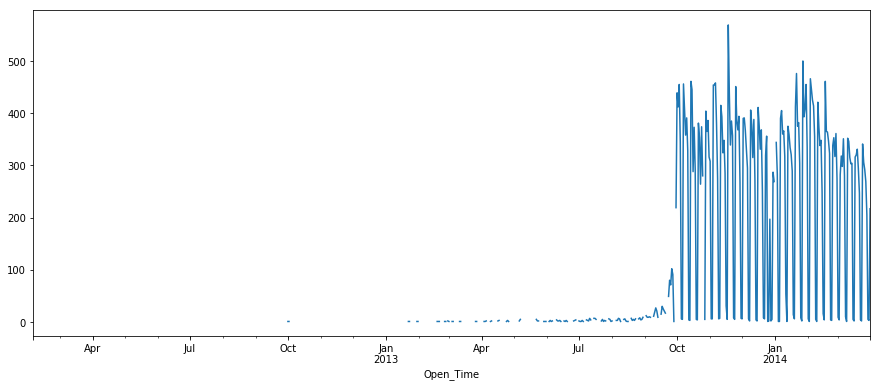

In [71]:
# Plotting number of tickets per day
data1.plot(figsize=(15,6))
plt.show()

In [72]:
# Since not many tickets before October 2013, we consider only the latter values
incfrom2013 = incfrq[incfrq.index > dt.datetime(2013,10,1)]

In [73]:
incfrom2013.head()

,No_Incidents
Open_Time,
2013-10-02,412
2013-10-03,455
2013-10-04,345
2013-10-07,456
2013-10-05,6


In [74]:
# new Series
data2 = incfrom2013['No_Incidents']
data2 = data2.asfreq('D')
data2.index

DatetimeIndex(['2013-10-02', '2013-10-03', '2013-10-04', '2013-10-05',
               '2013-10-06', '2013-10-07', '2013-10-08', '2013-10-09',
               '2013-10-10', '2013-10-11',
               ...
               '2014-03-22', '2014-03-23', '2014-03-24', '2014-03-25',
               '2014-03-26', '2014-03-27', '2014-03-28', '2014-03-29',
               '2014-03-30', '2014-03-31'],
              dtype='datetime64[ns]', name='Open_Time', length=181, freq='D')

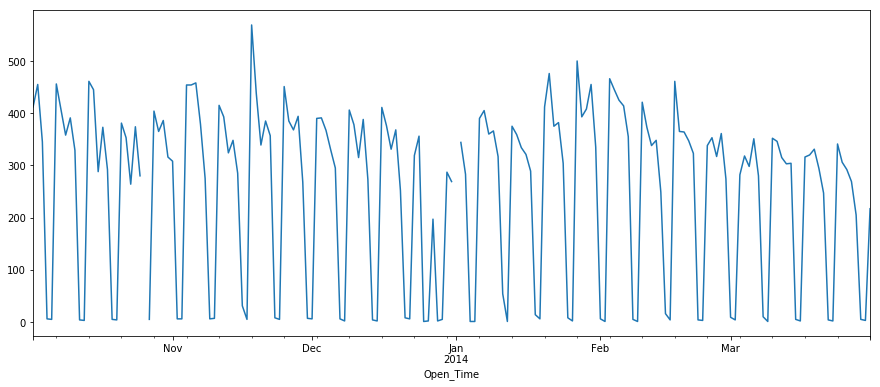

In [75]:
# Plotting number of tickets per day after October 2013
data2.plot(figsize=(15,6))
plt.show()

In [76]:
# Making a list of values for p,d & q
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))

In [77]:
# Checking the AIC values per pairs
for param in pdq:
    mod = sm.tsa.statespace.SARIMAX(data2,order=param,enforce_stationarity=False,enforce_invertibility=False)
    results = mod.fit()
    print('ARIMA{} - AIC:{}'.format(param, results.aic))

ARIMA(0, 0, 0) - AIC:2539.6180293605685
ARIMA(0, 0, 1) - AIC:2373.785382472224
ARIMA(0, 1, 0) - AIC:2371.128960804689
ARIMA(0, 1, 1) - AIC:2313.1363338175497
ARIMA(1, 0, 0) - AIC:2365.2916469365928
ARIMA(1, 0, 1) - AIC:2337.312508693352
ARIMA(1, 1, 0) - AIC:2373.1280680651544
ARIMA(1, 1, 1) - AIC:2294.4315812436407


In [78]:
# Choosing the model with minimum AIC and the ARIMA Model for Time Series Forecasting
mod = sm.tsa.statespace.SARIMAX(data2,order=(1,1,1))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3386      0.090      3.771      0.000       0.163       0.515
ma.L1         -0.9989      0.428     -2.332      0.020      -1.839      -0.159
sigma2       2.52e+04   9781.753      2.576      0.010    6023.470    4.44e+04


In [79]:
# Predicting the future values and the confidence interval
pred = results.get_prediction(start=pd.to_datetime('2014-3-3'),end=pd.to_datetime('2014-10-30'),dynamic=False)
pred_ci = pred.conf_int()
pred.predicted_mean.round()

2014-03-03    172.0
2014-03-04    266.0
2014-03-05    279.0
2014-03-06    272.0
2014-03-07    291.0
2014-03-08    267.0
2014-03-09    174.0
2014-03-10    169.0
2014-03-11    289.0
2014-03-12    288.0
2014-03-13    277.0
2014-03-14    273.0
2014-03-15    274.0
2014-03-16    171.0
2014-03-17    169.0
2014-03-18    276.0
2014-03-19    278.0
2014-03-20    282.0
2014-03-21    269.0
2014-03-22    253.0
2014-03-23    170.0
2014-03-24    168.0
2014-03-25    284.0
2014-03-26    272.0
2014-03-27    267.0
2014-03-28    260.0
2014-03-29    238.0
2014-03-30    169.0
2014-03-31    167.0
2014-04-01    240.0
              ...  
2014-10-01    252.0
2014-10-02    252.0
2014-10-03    252.0
2014-10-04    252.0
2014-10-05    252.0
2014-10-06    252.0
2014-10-07    252.0
2014-10-08    252.0
2014-10-09    252.0
2014-10-10    252.0
2014-10-11    252.0
2014-10-12    252.0
2014-10-13    252.0
2014-10-14    252.0
2014-10-15    252.0
2014-10-16    252.0
2014-10-17    252.0
2014-10-18    252.0
2014-10-19    252.0


### Visualization

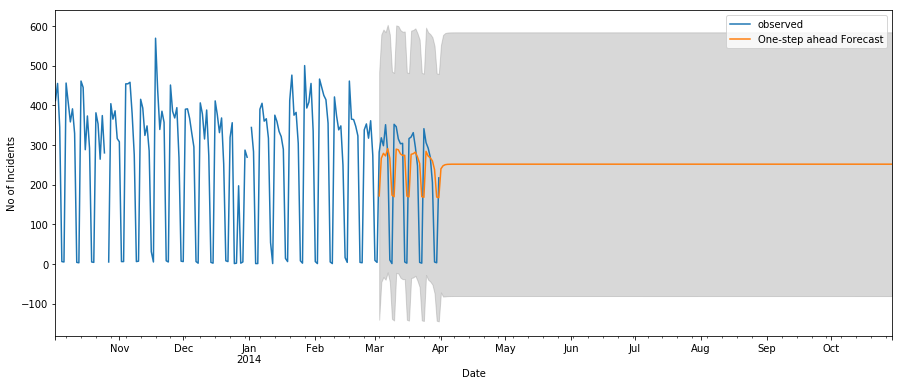

In [80]:
ax = data2['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax,label='One-step ahead Forecast',figsize=(15, 6))
ax.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],color='grey',alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('No of Incidents')
plt.legend()
plt.show()